# Case study of uniaxial compression tests

This is an example of how to use Paramaterial to process a dataset of uniaxial compression test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import paramaterial as pam
from paramaterial.plug import DataSet, DataItem
%matplotlib inline

## Data preparation


### Raw data
1. Create two directories: "data", "info".
2. Save all csv files into a directory called "data/01 raw data".
3. Generate a corresponding info table using make_info_table function.
4. Fill in the raw info and apply a naming convention.
5. Rename the files

In [2]:
# raw_info = pam.preparing.make_info_table('data/01 raw data', columns=['temperature', 'rate', 'material'])
# raw_info.to_excel('info/00 info unfilled.xlsx')
# raw_info.head()

Add the metadata into the excel spreadsheet.
Apply a naming convention in the "test id" column.

In [3]:
# raw_info = pd.read_excel('info/01 raw info.xlsx')
# raw_info.head()

Copy raw data and info into backup, incase raw data becomes damaged during processing.

In [4]:
# pam.preparing.copy_data_and_info(old_data_dir='data/01 raw data', new_data_dir='data/00 backup data',
#                                  old_info_path='info/01 raw info.xlsx', new_info_path='info/00 backup info.xlsx')

### Prepared data

Rename files according to test id.

In [5]:
# pam.preparing.rename_by_test_id('data/01 raw data', 'info/01 raw info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [6]:
# pam.preparing.check_column_headers('data/01 prepared data')

In [7]:
raw_set = DataSet('data/01 raw data', 'info/01 raw info.xlsx')

### Dataitem EDA
Look at one dataitem. Notice the use of the square brackets to get a subset, then to get a slice, then to get a single item.

In [8]:
raw_item = raw_set[{'rate': [1], 'material': ['H560']}][0:2][0]  # speed up get slice
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][1]
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][2]

raw_item

DataItem with test id baron_test_065.
Info: {'test id': 'baron_test_065', 'old filename': 'testID_0148.csv', 'test type': 'UC', 'material': 'H560', 'temperature': 360, 'rate': 1, 'L_0': 15, 'D_0': 10}
Data:    Time(sec)  Force(kN)   Jaw(mm)  PowAngle(deg)  Power(W)       Pram  \
0        0.0   0.913843  0.511157            0.0         0  10.594783   
1        0.1   0.907306  0.024974            0.0         0  10.594783   

      PTemp    Strain  Stress(MPa)  Stroke(mm)     TC1(C)  wedge(mm)  
0  0.001362  0.034665    11.233622   10.594357  25.704758  -9.116560  
1  0.219614  0.001707    11.535138   10.595199  25.719183  -9.463981  

In [9]:
raw_item.data = raw_item.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'Stroke(mm)', 'wedge(mm)', 'PTemp'])
# sns.pairplot(pd.concat([dataitem.data.iloc[:-199:200], dataitem.data.iloc[-10:]]), hue='TC1(C)', palette='plasma')

### Dataset EDA

In [10]:
raw_set.info_table.nunique()

test id         167
old filename    167
test type         1
material          3
temperature       6
rate              4
L_0               1
D_0               1
dtype: int64

In [57]:
index = ['material', 'rate']
columns = ['temperature']
raw_set.info_table.groupby(index + columns).size().unstack(columns).fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Make the experimental matrix.

In [11]:
data_matrix = raw_set.info_table[['material', 'temperature', 'rate']].value_counts().sort_index()
data_matrix = data_matrix.to_frame().reset_index()
data_matrix.columns = ['material', 'temperature', 'rate', 'count']
data_matrix.pivot_table(index=['material', 'rate'], columns='temperature', values='count').fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Plot the dataset.

<AxesSubplot:xlabel='Strain'>

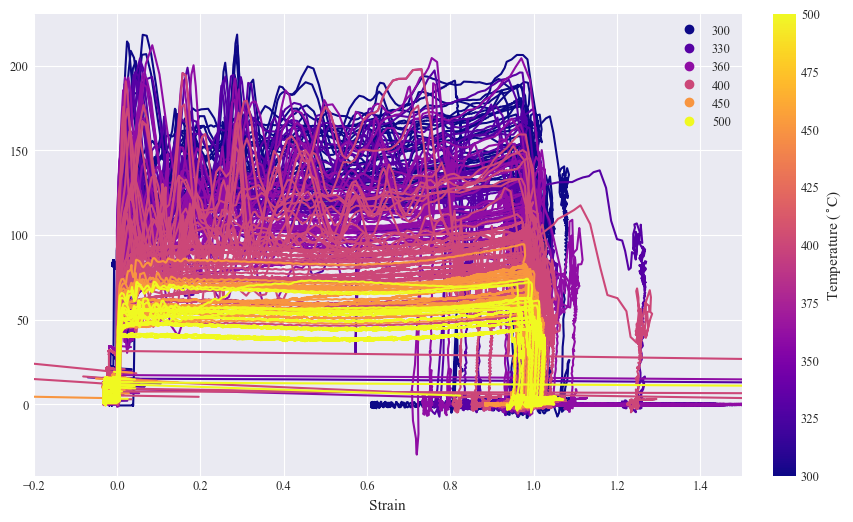

In [12]:
color_by = 'temperature'
color_norm = plt.Normalize(vmin=raw_set.info_table[color_by].min(), vmax=raw_set.info_table[color_by].max())

def ds_plot(dataset: DataSet, **kwargs) -> plt.Axes:
    return pam.plotting.dataset_plot(
        dataset, x='Strain', y='Stress(MPa)', color_by='temperature',
        cbar=True, cbar_label='Temperature ($^{\circ}$C)',
        xlim=(-0.2, 1.5), grid=True, color_norm=color_norm, **kwargs
    )

ds_plot(raw_set)

(<Figure size 1200x800 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'1 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'50 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>]],
       dtype=object))

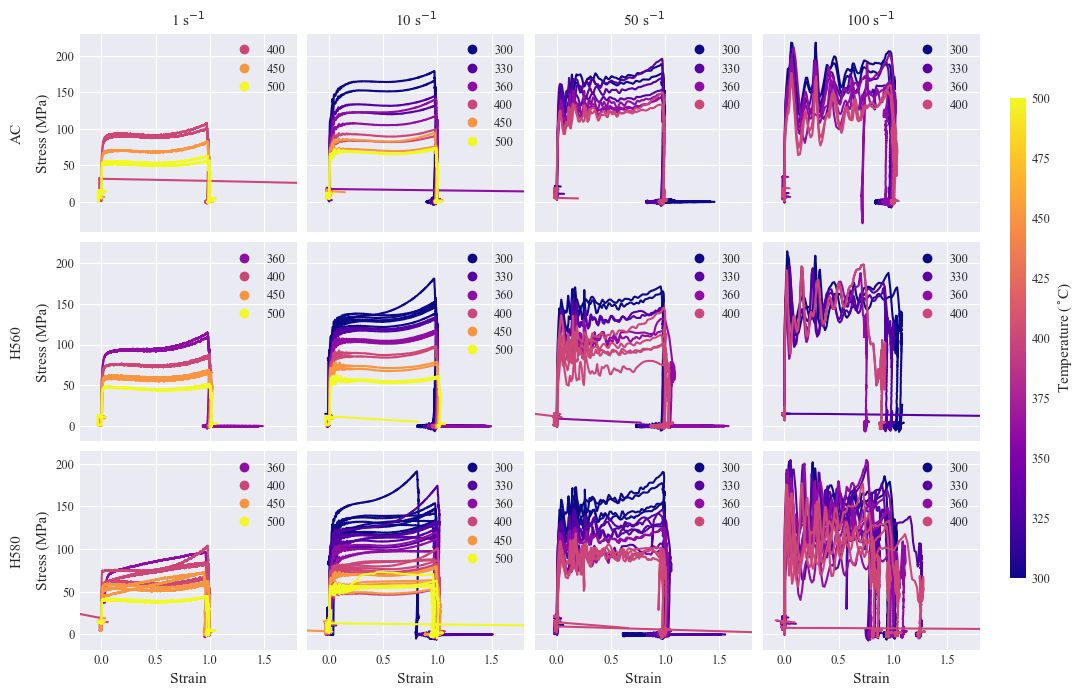

In [13]:
def ds_subplot(dataset: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
    dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
    shape=(3,4), rows_by='material', cols_by='rate',
    row_vals=[['AC'], ['H560'], ['H580']], col_vals=[[1], [10], [50], [100]],
    row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
    color_by='temperature', cbar=True, cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.8), grid=True, wspace=0.05, hspace=0.05, **kwargs
    )

ds_subplot(raw_set)

## Processing
We now want to:
- Trim the data
- Apply friction corrections
- Make representative curves
- Screen the data

### Trimming the data
- Remove unnecessary columns
- Trim leading and trailing data using time-step change
- Trim remaining trailing data after max force

In [14]:
def drop_columns(di: DataItem) -> DataItem:
    di.data = di.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)'])
    return di

raw_set = raw_set.map_function(drop_columns)
# raw_set

#### Trim using sampling rate change
After calculating the time-steps, we remove data that was sampled with a larger time-step.

<AxesSubplot:>

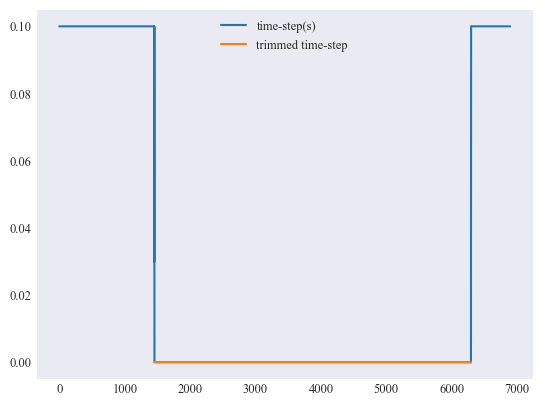

In [15]:
# calculate time-step
raw_item = raw_set[0]
time_step = np.diff(raw_item.data['Time(sec)'])
raw_item.data['time-step(s)'] = np.hstack([time_step[0], time_step])
ax = raw_item.data.plot(y='time-step(s)')

# trim by time-step
raw_item.data = raw_item.data[raw_item.data['time-step(s)'] < 0.02]
raw_item.data.plot(ax=ax, y='time-step(s)', label='trimmed time-step')

Trim dataset using time-step change. Notice how the origin data has been cleaned.

<AxesSubplot:xlabel='Strain'>

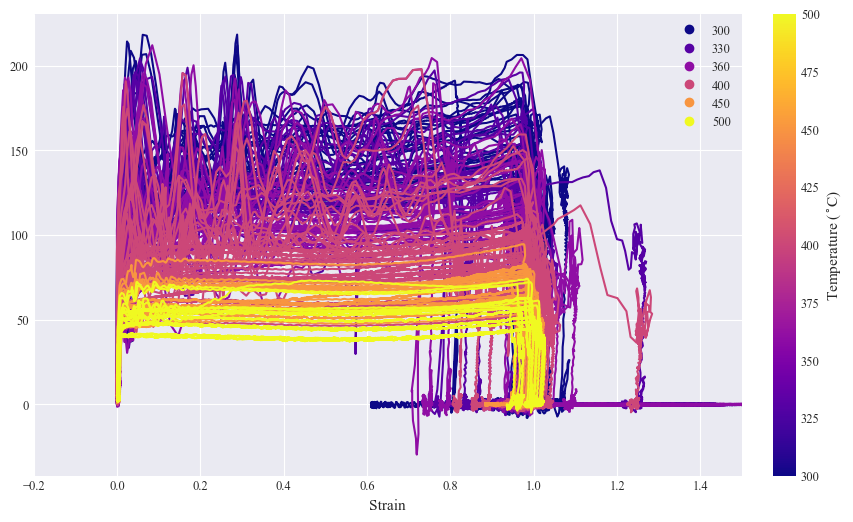

In [16]:
def trim_using_time_step_change(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02]
    return di


trim_set = raw_set.map_function(trim_using_time_step_change)
ds_plot(trim_set)
# ds_subplot(trimmed_dataset)

#### Trim using max force
The end of a compression test can be identified my the maximum force.

<AxesSubplot:xlabel='Strain'>

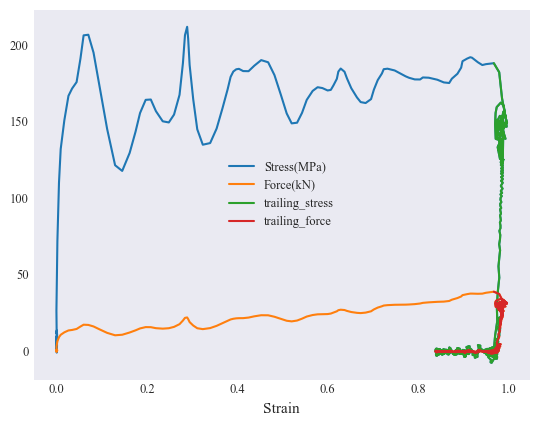

In [17]:
# investigate using max force index for trimming stress
raw_item = trim_set[0]

max_force_index = raw_item.data['Force(kN)'].idxmax()
trailing_data = raw_item.data.iloc[max_force_index:].copy()
trailing_data[['trailing_stress', 'trailing_force']] = trailing_data[['Stress(MPa)', 'Force(kN)']]
trailing_data['trailing_force'] = trailing_data['Force(kN)']

ax = raw_item.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])
trailing_data.plot(ax=ax, x='Strain', y=['trailing_stress', 'trailing_force'])

In [18]:
# demonstrate max force trimming for one dataitem
def remove_trailing_data(di: DataItem):
    di.data = di.data.iloc[:di.data['Force(kN)'].idxmax()]
    return di

trimmed_dataitem = remove_trailing_data(raw_item)
# trimmed_dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])

Trim dataset using max force. Notice how the trailing data is trimmed.

<AxesSubplot:xlabel='Strain'>

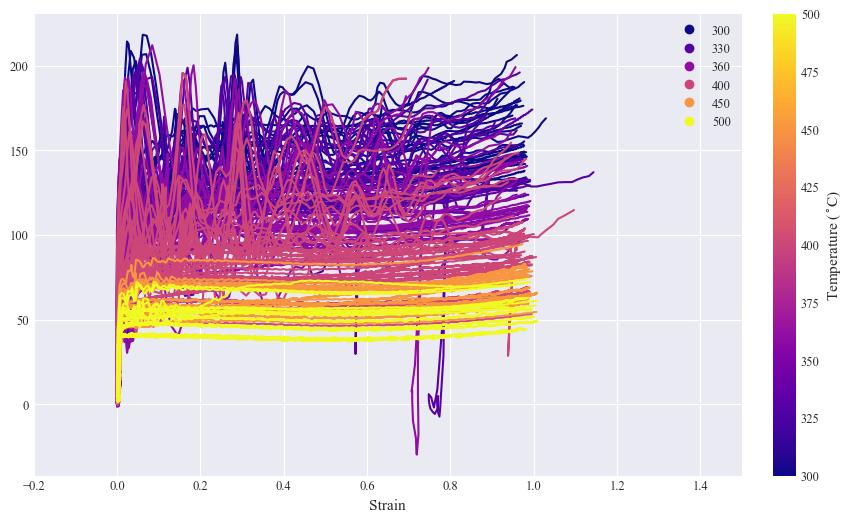

In [19]:
trim_set = trim_set.map_function(remove_trailing_data)
ds_plot(trim_set)

Save trimmed data.

In [20]:
trim_set.write_output('data/02 trimmed data', 'info/02 trimmed info.xlsx')

In [25]:
corr_set.write_output('data/03 corrected data', 'info/03 corrected info.xlsx')

### Make representative curves

In [26]:
pam.processing.make_representative_curves(DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx'),
                                          'data/02 repr trim data', 'info/02 repr trim info.xlsx',
                                          repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
                                          interp_by='Strain')

(<Figure size 1200x800 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'1 s$^{-1}$'}, xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'50 s$^{-1}$'}, xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='interp_Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='interp_Strain', ylabel='Stress (

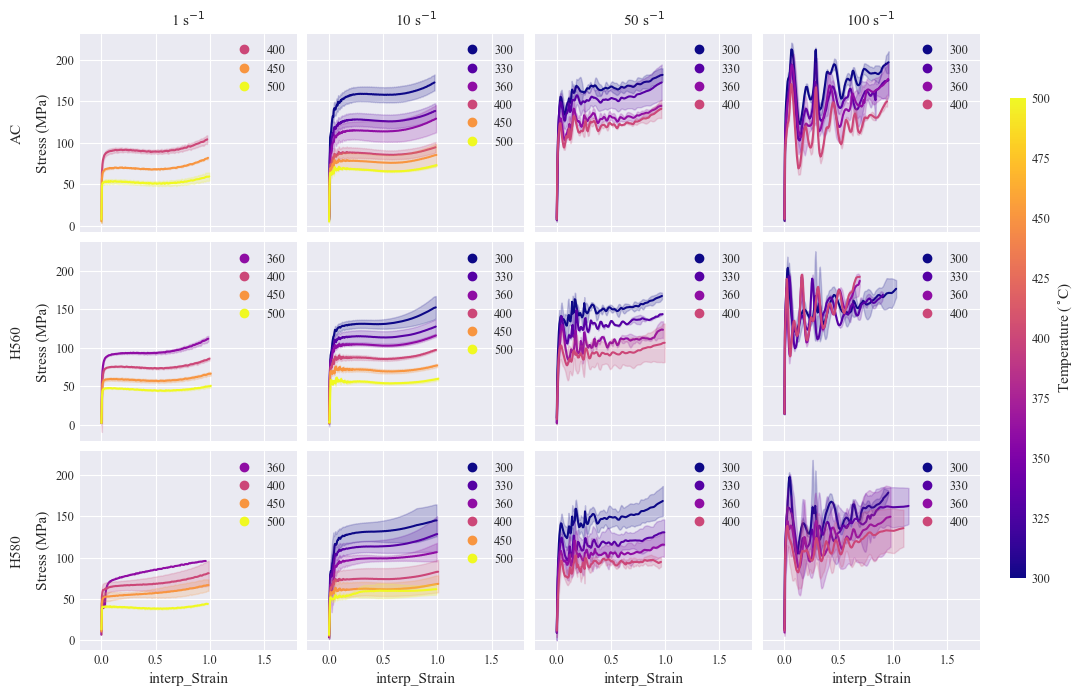

In [27]:
def repr_ds_subplot(dataset: DataSet):
    return pam.plotting.dataset_subplots(
    dataset, x='interp_Strain', y='mean_Stress(MPa)', ylabel='Stress (MPa)',
    shape=(3,4), rows_by='material', cols_by='rate',
    row_vals=[['AC'], ['H560'], ['H580']], col_vals=[[1], [10], [50], [100]],
    row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
    color_by='temperature', cbar=True, cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.8), grid=True, wspace=0.05, hspace=0.05, fill_between=('down_std_Stress(MPa)', 'up_std_Stress(MPa)')
    )

repr_ds_subplot(DataSet('data/02 repr trim data', 'info/02 repr trim info.xlsx', test_id_key='repr id'))

In [28]:
# pam.processing.make_representative_curves(DataSet('data/03 corrected data', 'info/03 corrected info.xlsx'),
#                                           'data/03 repr corr data', 'info/03 repr corr info.xlsx',
#                                           repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
#                                           interp_by='Strain')

Iterating over DataItems: 2it [00:00,  2.95it/s]
Iterating over DataItems: 2it [00:00,  2.68it/s]
Iterating over DataItems: 2it [00:00,  2.94it/s]
Iterating over DataItems: 2it [00:00,  2.97it/s]
Iterating over DataItems: 2it [00:00,  2.99it/s]
Iterating over DataItems: 2it [00:00,  2.90it/s]
Iterating over DataItems: 2it [00:00,  2.92it/s]
Iterating over DataItems: 2it [00:00,  2.95it/s]
Iterating over DataItems: 6it [00:00,  8.83it/s]
Iterating over DataItems: 6it [00:00,  8.54it/s]
Iterating over DataItems: 2it [00:00,  2.94it/s]
Iterating over DataItems: 2it [00:00,  2.89it/s]
Iterating over DataItems: 2it [00:00,  2.94it/s]
Iterating over DataItems: 2it [00:00,  2.94it/s]
Iterating over DataItems: 9it [00:00, 13.26it/s]
Iterating over DataItems: 9it [00:00, 12.75it/s]
Iterating over DataItems: 4it [00:00,  5.83it/s]
Iterating over DataItems: 4it [00:00,  5.85it/s]
Iterating over DataItems: 2it [00:00,  2.97it/s]
Iterating over DataItems: 2it [00:00,  2.89it/s]
Iterating over DataI

In [29]:
# repr_ds_subplot(DataSet('data/03 repr corr data', 'info/03 repr corr info.xlsx', test_id_key='repr id'))

### Screening
1. Make a screening pdf from the trimmed data.
2. Mark the pdf.
3. Run screening using the marked pdf to discard unwanted items.

Make a plot for the screening pdf. Test it on a dataitem. Make the screening pdf.

In [30]:
trim_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')
repr_set = DataSet('data/02 repr trim data', 'info/02 repr trim info.xlsx', test_id_key='repr id')

def screening_plot(di: DataItem) -> None:
    """Screening plot function."""

    # get other similar data items
    subset_cfg = {'material': [di.info['material']], 'temperature': [di.info['temperature']], 'rate': [di.info['rate']]}
    similar_set = trim_set[subset_cfg]

    # get associated representative data
    repr_item_set = repr_set[subset_cfg]
    assert len(repr_item_set) == 1  # should be only one repr item

    # plot dataitem
    _ax = di.data.plot(x='Strain', y='Stress(MPa)', color='k', legend=False)

    # plot representative curve
    _ax = pam.plotting.dataset_plot(
        repr_item_set, x='interp_Strain', y='mean_Stress(MPa)', ylabel='Stress (MPa)', ax=_ax,
        color_by='temperature', color_by_label=r'Temp (${^\circ}$C):', color_norm=color_norm,
        style_by='material', style_by_label='Material:', width_by='rate', width_by_label='Rate (s$^{-1}$):',
        xlim=(-0.2, 1.5), grid=True, fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'), alpha=0.2,
        figsize=(10, 5.8),
    )

    # plot similar curves
    _ax = pam.plotting.dataset_plot(
        similar_set, x='Strain', y='Stress(MPa)', ax=_ax, color_by='temperature', color_by_label=r'Temp (${^\circ}$C):',
        color_norm=color_norm, style_by='material', style_by_label='Material:', width_by='rate',
        width_by_label='Rate (s$^{-1}$):', xlim=(-0.2, 1.5), grid=True,
        alpha=0.5, figsize=(10, 5.8),
    )

    # add title with number of similar curves
    _ax.set_title(f'{len(similar_set)} similar curves')
    _ax.set_title(f'{di.info["material"]} at {di.info["temperature"]} C and {di.info["rate"]} s$^{{-1}}$. '
                 f'One of {len(similar_set)}.')

# test screening plot
# screening_plot(trim_set[0])
# make pdf
# pam.processing.make_screening_pdf(trim_set, screening_plot, 'data/01 trimmed data screening.pdf')

Iterating over DataItems: 0it [00:00, ?it/s]
Iterating over DataItems: 1it [00:00,  6.50it/s]

Iterating over DataItems: 2it [00:00,  3.29it/s]
Iterating over DataItems: 1it [00:02,  2.61s/it]
Iterating over DataItems: 1it [00:00,  6.40it/s]

Iterating over DataItems: 2it [00:00,  3.29it/s]
Iterating over DataItems: 2it [00:05,  2.53s/it]
Iterating over DataItems: 1it [00:00,  6.40it/s]

Iterating over DataItems: 2it [00:00,  3.32it/s]
Iterating over DataItems: 3it [00:07,  2.51s/it]
Iterating over DataItems: 1it [00:00,  5.70it/s]

Iterating over DataItems: 2it [00:00,  2.69it/s]
Iterating over DataItems: 4it [00:10,  2.69s/it]
Iterating over DataItems: 1it [00:00,  4.77it/s]

Iterating over DataItems: 3it [00:00,  4.77it/s]
Iterating over DataItems: 5it [00:13,  2.72s/it]
Iterating over DataItems: 1it [00:00,  7.11it/s]

Iterating over DataItems: 3it [00:00,  4.49it/s]
Iterating over DataItems: 6it [00:16,  2.75s/it]
Iterating over DataItems: 1it [00:00,  5.32it/s]

Iterating over Da

Screening pdf saved to data/01 trimmed data screening.pdf.


Delete the rejected data. Once this has been done, re-make the representative data.

In [28]:
trim_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')
pam.processing.screen_data(trim_set, 'data/screened/02 trimmed data screening marked 21Oct18h57.pdf',
                           'data/screened/02 trim screen data', 'info/screened/02 trim screen info.xlsx')

Screening complete. 23 tests rejected.
Rejected tests saved to data/02 trimmed data.


In [33]:
trim_screen_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')
trim_screen_set.info_table['comment'].dropna()

5               trim at 0.6
82              trim at 0.6
83              trim at 0.5
94     close to wrong shape
109             wrong shape
110             wrong shape
133             trim at 0.8
142             trim at 0.6
Name: comment, dtype: object

Process based on screening comments.

In [43]:
def screening_comment_function(di: DataItem) -> DataItem:
    if str(di.info['comment']).startswith('trim at'):
        trim_strain = di.info['comment'].split(' ')[2]
        di.data = di.data[di.data['Strain'] <= float(trim_strain)]
        print(f'Trimming {di.test_id} at {trim_strain} strain.')
        return di
    else:
        return di

comment_fixed_set = trim_screen_set.map_function(screening_comment_function)
comment_fixed_set.write_output('data/04 screened trimmed data', 'info/04 screened trimmed info.xlsx')

14DataItems [00:00, 55.47DataItems/s]

Trimming baron_test_006 at 0.6 strain.


97DataItems [00:01, 60.92DataItems/s]

Trimming baron_test_087 at 0.6 strain.
Trimming baron_test_088 at 0.5 strain.


Trimming baron_test_156 at 0.8 strain.
Trimming baron_test_166 at 0.6 strain.


Trimming baron_test_006 at 0.6 strain.
Trimming baron_test_087 at 0.6 strain.
Trimming baron_test_088 at 0.5 strain.
Trimming baron_test_156 at 0.8 strain.
Trimming baron_test_166 at 0.6 strain.


### Applying the friction correction.
$$
\sigma = P \left[\frac{h}{\mu d} \right]^{-2}\left[\exp\left(\frac{\mu d}{h}\right) - \frac{\mu d}{h} - 1 \right]^{-1}
$$

Demonstrate friction correction for one dataitem

In [44]:
# uncorr_item = DataSet
#
# # apply friction correction function to dataset
# def friction_correction(di: DataItem) -> DataItem:
#     mu = 0.3  # friction coefficient
#     h_0 = di.info['L_0']  # initial height in axial direction
#     d_0 = di.info['D_0']  # initial diameter
#     h = h_0 - di.data['Jaw(mm)']  # instantaneous height
#     d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
#     P = di.data['Force(kN)']*1000*4/(np.pi*d ** 2)  # pressure (MPa)
#     di.data['Pressure(MPa)'] = P
#     di.data['raw stress'] = di.data['Stress(MPa)']
#     di.data['Stress(MPa)'] = P/(1 + (mu*d)/(3*h))  # correct stress
#     return di
#
# corr_item = friction_correction(uncorr_item)
# corr_item.data.plot(x='Strain', y=['raw stress', 'Stress(MPa)'])

Apply friction correction to dataset.

In [46]:
# corr_set = trim_set.map_function(friction_correction)

Compare corrected to un-corrected for a subset

In [47]:
# subset_filter = {'material': ['H560'], 'rate': [1], 'temperature': [400, 500]}
# ax = ds_plot(trim_set[subset_filter], alpha=0.3)
# fig = ax.get_figure()
# fig.delaxes(fig.axes[1])
# ds_plot(corr_set[subset_filter], ax=ax)

In [48]:
# fig, axs = ds_subplot(trim_set, alpha=0.3, linestyle=':')
# ds_subplot(corr_set, fig=fig, axs=axs)
# ax = ds_plot(corr_set, alpha=0.8)
# ds_plot(trim_set, ax=ax, alpha=0.3)

### Write corrected data to new folder

In [50]:
# corr_set = DataSet('data/03 corrected data', 'info/03 corrected info.xlsx')
# pam.processing.screen_data(corr_set, 'data/screened/02 trimmed data screening marked 21Oct18h57.pdf',
#                            'data/screened/03 corr screen data', 'info/screened/03 corr screen info.xlsx')

## Modelling
1. Identify points of interest algorithmically
2. Fit material model

### Reference results
This table of results was produced in a separate analysis. It is unclear at what strain the mean temperature and flow stress were determined. We will try at 0.1 strain and at 0.3 strain.

In [10]:
reference_table = pd.read_excel('report/baron quoted results.xlsx')
reference_table = reference_table.rename(columns={
        'Strain-rate (s^-1)': 'rate', 'Nominal temperature': 'temperature', 'Material condition': 'material',
        'Mean temperature': 'mean temperature', 'Mean flow stress (MPa)': 'mean flow stress'
    })
reference_table = reference_table.set_index(['material', 'rate', 'temperature']).sort_index().reset_index()
reference_table

,material,rate,temperature,mean temperature,mean flow stress
0,AC,1,400,409.86,83.80
1,AC,1,450,460.37,64.21
2,AC,1,500,515.92,45.17
3,AC,10,300,332.28,150.32
4,AC,10,330,381.92,116.56
5,AC,10,360,405.58,103.12
6,AC,10,400,454.48,77.58
7,AC,10,450,479.09,69.04
8,AC,10,500,512.71,61.76
9,H560,1,400,412.20,73.43


### Analysis results
We want to repeat the analysis using Paramaterial and compare results.
The following steps are required:
1. Get the relevant subset
2. Apply function to read temperature and flow stress at 0.1 and 0.3 strain
3. Performing averaging
4. Compare results

Run analysis.

In [3]:
analysis_set = DataSet('data/04 screened trimmed data', 'info/04 screened trimmed info.xlsx')[{'rate': [1, 10]}]

def read_temp_and_stress(di: DataItem) -> DataItem:
    # interpolate the temperature and stress at 0.1 strain and 0.3 strain
    di.info['0.1 temperature'] = np.interp(0.1, di.data['Strain'], di.data['TC1(C)'])
    di.info['0.3 temperature'] = np.interp(0.3, di.data['Strain'], di.data['TC1(C)'])
    di.info['0.1 stress'] = np.interp(0.1, di.data['Strain'], di.data['Stress(MPa)'])
    di.info['0.3 stress'] = np.interp(0.3, di.data['Strain'], di.data['Stress(MPa)'])
    return di

analysis_set = analysis_set.apply_function(read_temp_and_stress)
analysis_set.info_table.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0,reject,comment,0.1 temperature,0.3 temperature,0.1 stress,0.3 stress
0,baron_test_010,testID_0089.csv,UC,AC,300,10,15,10,n,NaN,299.334214,301.699192,153.994117,165.43268
1,baron_test_011,testID_0090.csv,UC,AC,300,10,15,10,n,NaN,306.924261,324.155901,143.113131,152.506357
2,baron_test_012,testID_0092.csv,UC,AC,330,10,15,10,n,NaN,332.823727,344.563887,127.48229,133.620486
3,baron_test_013,testID_0094.csv,UC,AC,330,10,15,10,n,NaN,340.306165,373.923177,118.241235,122.323857
4,baron_test_014,testID_0095.csv,UC,AC,360,10,15,10,n,NaN,359.28395,359.58028,103.543753,106.913398


Check for outliers.

array([[<AxesSubplot:title={'center':'0.1 temperature'}, xlabel='material'>,
        <AxesSubplot:title={'center':'0.3 temperature'}, xlabel='material'>],
       [<AxesSubplot:title={'center':'0.1 stress'}, xlabel='material'>,
        <AxesSubplot:title={'center':'0.3 stress'}, xlabel='material'>]],
      dtype=object)

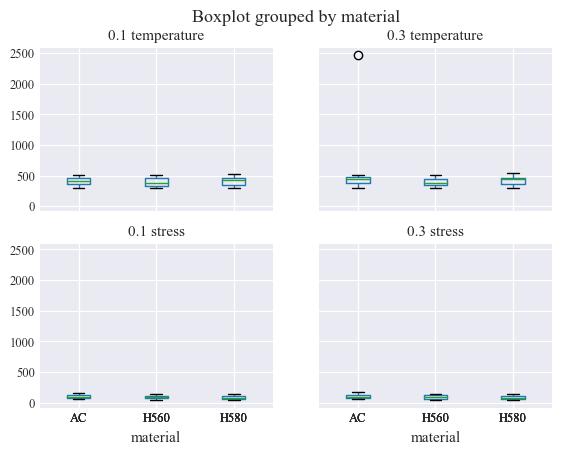

In [5]:
analysis_table = analysis_set.info_table[['test id' ,'material', 'temperature', 'rate', '0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress']]
analysis_table.boxplot(by='material', column=['0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress'])

In [6]:
analysis_table = analysis_table.groupby(['material', 'temperature', 'rate']).mean().reset_index()
analysis_table

C:\Users\DS\AppData\Local\Temp\ipykernel_5732\1228197858.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  analysis_table = analysis_table.groupby(['material', 'temperature', 'rate']).mean().reset_index()


,material,temperature,rate,0.1 temperature,0.3 temperature,0.1 stress,0.3 stress
0,AC,300,10,303.129238,312.927546,148.553624,158.969519
1,AC,330,10,336.564946,359.243532,122.861762,127.972171
2,AC,360,10,360.954139,370.610332,111.018512,114.726599
3,AC,400,1,399.958547,402.510396,90.567392,90.942693
4,AC,400,10,409.946278,436.382142,86.749595,87.744664
5,AC,450,1,451.028788,455.117874,69.626003,69.408445
6,AC,450,10,460.153914,468.720171,77.933556,78.023345
7,AC,500,1,501.594834,501.601020,53.389852,52.524360
8,AC,500,10,499.632896,1480.613651,69.091088,67.846606
9,H560,300,10,308.956735,311.493056,125.447222,130.543765


Investigate outlier.

In [28]:
analysis_table[analysis_table['0.3 temperature'] > 1000]

,test id,material,temperature,rate,0.1 temperature,0.3 temperature,0.1 stress,0.3 stress
11,baron_test_021,AC,500,10,500.003956,2466.564365,69.538203,68.4522


<AxesSubplot:xlabel='Strain'>

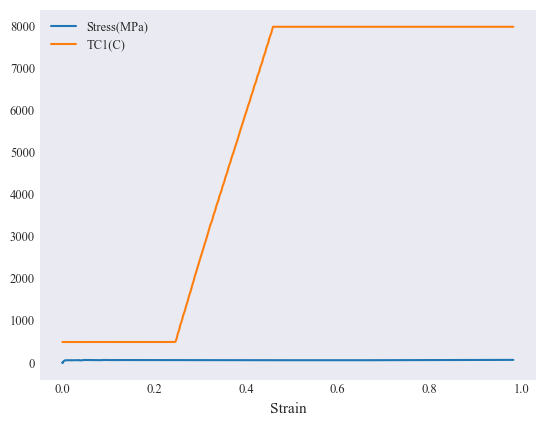

In [30]:
analysis_set[11].data.plot(x='Strain', y=['Stress(MPa)', 'TC1(C)'])

Remove outlier.

array([[<AxesSubplot:title={'center':'0.1 temperature'}, xlabel='material'>,
        <AxesSubplot:title={'center':'0.3 temperature'}, xlabel='material'>],
       [<AxesSubplot:title={'center':'0.1 stress'}, xlabel='material'>,
        <AxesSubplot:title={'center':'0.3 stress'}, xlabel='material'>]],
      dtype=object)

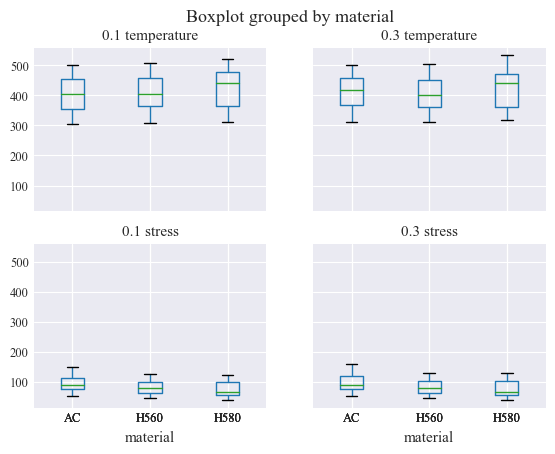

In [7]:
analysis_table = analysis_table[analysis_table['0.3 temperature'] < 1000]
analysis_table.boxplot(by='material', column=['0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress'])

### Compare reference and analysis
Combine reference results and analysis for comparison.

In [11]:
# analysis_table.drop(columns=['test id'], inplace=True)
merged_table = pd.merge(reference_table, analysis_table, on=['material', 'rate', 'temperature'])
merged_table

,material,rate,temperature,mean temperature,mean flow stress,0.1 temperature,0.3 temperature,0.1 stress,0.3 stress
0,AC,1,400,409.86,83.80,399.958547,402.510396,90.567392,90.942693
1,AC,1,450,460.37,64.21,451.028788,455.117874,69.626003,69.408445
2,AC,1,500,515.92,45.17,501.594834,501.601020,53.389852,52.524360
3,AC,10,300,332.28,150.32,303.129238,312.927546,148.553624,158.969519
4,AC,10,330,381.92,116.56,336.564946,359.243532,122.861762,127.972171
5,AC,10,360,405.58,103.12,360.954139,370.610332,111.018512,114.726599
6,AC,10,400,454.48,77.58,409.946278,436.382142,86.749595,87.744664
7,AC,10,450,479.09,69.04,460.153914,468.720171,77.933556,78.023345
8,H560,1,400,412.20,73.43,407.256336,407.743579,75.357080,74.843221
9,H560,1,450,459.05,56.71,457.042755,452.129970,59.178691,58.157701


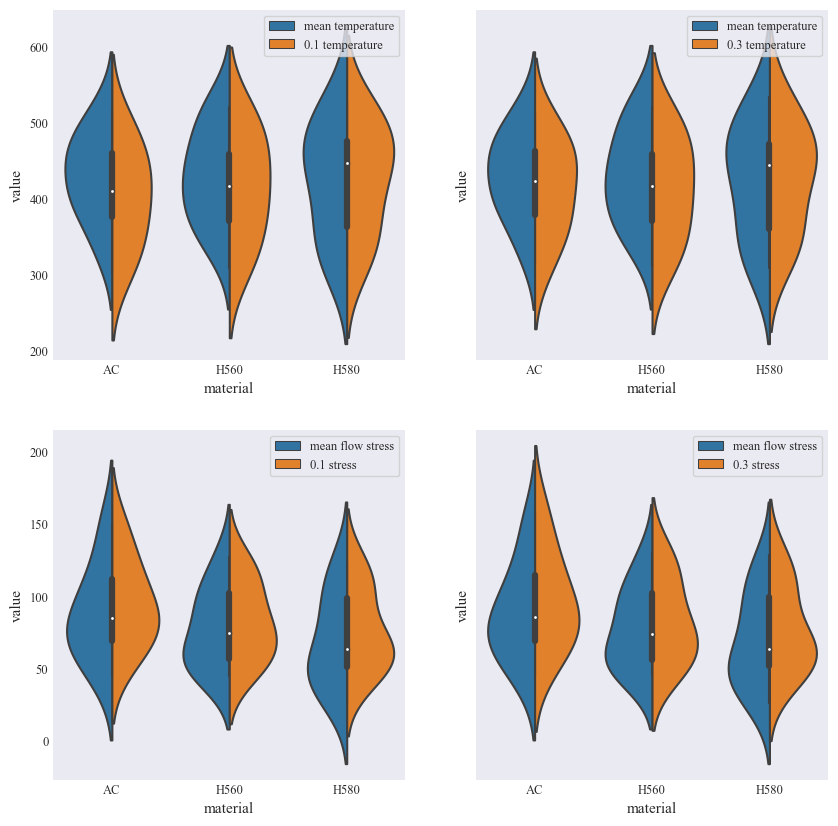

In [24]:
melt_df = pd.melt(merged_table, id_vars=['material', 'rate', 'temperature'],
                  value_vars=['mean temperature', '0.1 temperature', '0.3 temperature', 'mean flow stress', '0.1 stress', '0.3 stress'])

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row')

columns = [['mean temperature', '0.1 temperature'],['mean temperature', '0.3 temperature'],
           ['mean flow stress', '0.1 stress'], ['mean flow stress', '0.3 stress']]

for ax, cols in zip(axs.flat, columns):
    sns.violinplot(x='material', y='value', hue='variable', split=True,
                   ax=ax, data=melt_df[melt_df['variable'].isin(cols)])
    ax.legend(frameon=True)

Based on the violin plots, it looks like the 0.3 stress and temperature match the reference mean. We can confirm this using regression.

### Reference model

### Analysis model

### Model comparison